# Hamiltonians

This is an example of plotting hamiltonians in phase space distributions.
First, create a simple line, a tracker and a particle set:

In [1]:
import xtrack as xt
import xpart as xp
import xplt
import numpy as np

np.random.seed(43543557)

In [ ]:
## Generate a simple 6-fold symmetric FODO lattice

n = 6  # number of sections
s = 5  # number of dipole slices
elements = {
    "QF": xt.Multipole(length=0.3, knl=[0, +0.63]),
    "QD": xt.Multipole(length=0.3, knl=[0, -0.48]),
    "MU": xt.Multipole(length=0.5, knl=[np.pi / n], hxl=[np.pi / n]),
}
parts = {
    "a": [xt.Node(0.7, "QF"), xt.Node(1.4, "MU"), xt.Node(2.1, "QD"), xt.Node(2.8, "MU")],
    "b": [xt.Node(2.2, "MU"), xt.Node(2.9, "QD"), xt.Node(3.6, "MU"), xt.Node(4.3, "QF")],
}
nodes = [xt.Node(5.0 * i, "a" if i % 2 else "b", name=f"S{i+1}") for i in range(n)]

# sextupoles
for i in range(n):
    sx = xt.Multipole(length=0.2, knl=[0, 0, 0.5 * np.sin(2 * np.pi * (i / n))])
    nodes.append(xt.Node(0.2, sx, from_=f"S{i+1}", name=f"S{i+1}SX"))

# aperture
nodes.append(xt.Node(0, xt.LimitRect(min_x=-0.01, max_x=0.01), name="APERTURE"))

line = xt.Line.from_sequence(
    nodes, length=5.0 * n, sequences=parts, elements=elements, auto_reorder=True
)
line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=1e9)
tracker = xt.Tracker(line=line)

In [3]:
tw = tracker.twiss(
    method="4d",
    # at_s=np.linspace(0, line.get_length(), 500),
)
print(f"qx: {tw.qx:g}")
print(f"qy: {tw.qy:g}")

qx: 2.33247
qy: 1.12177


## Kobayashi Hamiltonian

The Kobayashi Hamiltonian describes the particle dynamics in the vicinity of a driven 3rd order resonance:

\begin{equation*}
H = 3\pi d \left(X^2 + X'^2\right) + \frac{S}{4} \left(3 X X'^2 - X^3\right)
\end{equation*}

with the tune distance d=q-r to the third integer resonance r=n/3 and the normalized sextupole strength:
$$
S = -\frac{1}{2} \beta_x^{3/2} k_2 l
$$


In [4]:
## Generate particles
line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=1e9)
nparticles = int(1e4)

# Transverse distribution (gaussian)
norm_emitt_x = 4e-6  # normalized 1-sigma emittance in m*rad (=beta*gamma*emitt_x)
norm_emitt_y = 1e-6  # normalized 1-sigma emittance in m*rad (=beta*gamma*emitt_y)
x, px = xp.generate_2D_gaussian(nparticles)
y, py = xp.generate_2D_gaussian(nparticles)

# Longitudinal distribution (coasting beam)
rel_momentum_spread = 1e-4  # relative momentum spread ( P/p0 - 1 )
zeta = line.get_length() * np.random.uniform(-0.5, 0.5, nparticles)
delta = rel_momentum_spread * xp.generate_2D_gaussian(nparticles)[0]

particles = xp.build_particles(
    tracker=tracker,
    particle_ref=line.particle_ref,
    x_norm=x,
    px_norm=px,
    nemitt_x=norm_emitt_x,
    y_norm=y,
    py_norm=py,
    nemitt_y=norm_emitt_y,
    method="4d",  # for twiss (default is 6d, won't work without a cavity)
    zeta=zeta,
    delta=delta,
)

In [5]:
## Track for a few turns and then stop at the sextupole
tracker.track(particles, num_turns=500, ele_stop=7)
print(f"{np.sum(particles.state <= 0)} of {len(particles.state)} particles lost")

## Determine twiss parameters for normalized phase space plots
tw = tracker.twiss(method="4d", at_elements=[7])

549 of 10000 particles lost


Phase space plot with separatrix and equipotential lines:

S = 2.075 m^(-1/2)
mu = -0.0700169 rad/2pi


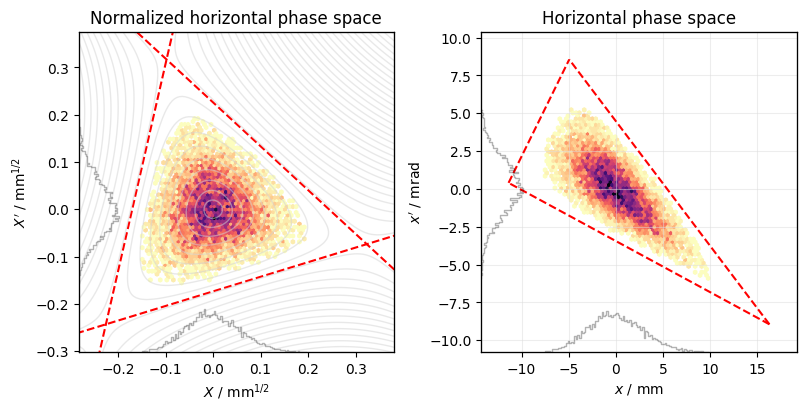

In [6]:
plot = xplt.PhaseSpacePlot(
    particles, mask=particles.state > 0, kind="X,x", twiss=tw, hist_kwargs=dict(gridsize=50)
)

# determine the virtual sextupole
S, mu = xplt.util.virtual_sextupole(tracker)

print(f"S = {S:g} m^(-1/2)")
print(f"mu = {mu:g} rad/2pi")

# plot the hamiltonian
plot.plot_hamiltonian_kobayashi(0, S=S, mu=mu, extend=5)
plot.plot_hamiltonian_kobayashi(1, S=S, mu=mu, equipotentials=False)

-----------------
```{seealso}
- {class}`xplt.phasespace`
```